In [9]:
import json
import pandas as pd
import re
import numpy as np


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'gdplus', 'unfr']
datasets_names = ['p1', 'p2', 'a1', 'a2', 'a3', 'a4', 'c1', 'c2', 'c3', 'c4', 'd1','d2','d3','d4','d5','d6', 'd7'] # do not use c5 and c6 because with 500 pbis its too slow

files_container = '../output/files_list_umda-pbil-geneticnds-mimic-feda' #  generated by running extract_postMetrics.py

       


## 1. Datasets insight

In [10]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI', '#(PBI-->[PBI])', '%(PBI-->[PBI])','Avg_len[PBI]'])

for name in datasets_names:
    ds = Dataset(source_file='..\datasets\\'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

    n_dependencies = sum(x is not None for x in ds.dependencies)
    ratio_pbi_with_deps =  n_dependencies / n_pbis
    avg_depends_per_pbi = 0
    for dep in ds.dependencies:
        avg_depends_per_pbi = avg_depends_per_pbi + len(dep) if dep is not None else avg_depends_per_pbi + 0
    avg_depends_per_pbi = avg_depends_per_pbi / n_dependencies

    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis,  '#(PBI-->[PBI])': n_dependencies, '%(PBI-->[PBI])': ratio_pbi_with_deps, 'Avg_len[PBI]':avg_depends_per_pbi}
    ds_summary = ds_summary.append(new_row, ignore_index=True)

display(ds_summary)




,Dataset,#Stakeholders,#PBI,#(PBI-->[PBI]),%(PBI-->[PBI]),Avg_len[PBI]
0,p1,5,20,7,0.350000,1.857143
1,p2,5,100,29,0.290000,2.689655
2,a1,5,50,18,0.360000,2.222222
3,a2,15,50,18,0.360000,2.722222
4,a3,5,200,74,0.370000,1.945946
5,a4,15,200,75,0.375000,2.253333
6,c1,15,50,20,0.400000,2.400000
7,c2,100,50,17,0.340000,3.529412
8,c3,15,200,69,0.345000,1.942029
9,c4,100,200,75,0.375000,2.093333


In [11]:


def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            parameters_dictios_list.append(dictio['parameters'])
            metrics_dictios_list.append(dictio['metrics'])
        
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    metrics_df = metrics_df[keep_metrics]
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)

    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=files

    return combined_df

In [12]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [13]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [14]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

## 2. Search of the best hyperparameters configuration for each algorithm.

    2.1 Best configuration for: FEDA

In [15]:
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'selection_scheme']

# files_container = '../output/filest_list_feda'

algorithm =  'feda'


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_feda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_feda, keep_parameters, "FEDA")
#display(df_feda)
best_config_feda, best_counts, ndatasets= get_best_configuration(data_df=df_feda, hyperparameters=keep_parameters, metric='HV')
best_for_feda_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_feda_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for FEDA is:")
for param in best_config_feda:
    print(f"{param}:{best_config_feda[param]}")


These are the different values used to set hyperparameters in FEDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
selection_scheme: ['nds']
In total, 25 configuration per dataset.

Counts of best configurations found in 17 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,selection_scheme,datasets,HV,wins
0,1000,300,0,nds,"[a1, a2, c2, c3, d2, d4]","[0.8728, 0.9435, 0.932, 0.9061, 0.8702, 0.808]",6.0
1,1000,50,0,nds,"[a3, a4, d1, d5, d7]","[0.8244, 0.8047, 0.9126, 0.812, 0.781]",5.0
2,1000,400,0,nds,"[c1, c4]","[0.8999, 0.8521]",2.0
3,1000,200,0,nds,"[d3, p1]","[0.8099, 0.8789]",2.0
4,1000,100,0,nds,"[d6, p2]","[0.8011, 0.7891]",2.0



Best hyperparameter configuration for FEDA is:
population_length:1000
max_generations:300
max_evaluations:0
selection_scheme:nds


    2.2 Best configuration for: GRASP

It takes too long. In the datasets in which results are available, GRASP's HV is better than all algorithms. However, in one week experiments did not finish for datasets with a large number of PBIs.

In [ ]:
#filest_list_GRASP contains all output files from the GRASP algorithm. Goal is to find the best hyperparameters configuration.

keep_parameters = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode']
 

files = []
with open(files_container, 'r') as f:
    for line in f:
        files.append('../'+str(line.replace('\n','')))

df_grasp = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_grasp, keep_parameters, "GRASP")

#display(df_grasp)

best_config_grasp, best_counts, ndatasets= get_best_configuration(data_df=df_grasp, hyperparameters=keep_parameters, metric='HV')
best_for_grasp_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)

print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")

display(best_for_grasp_df.drop(['file'], axis=1, inplace=False))


print(f"\nBest hyperparameter configuration for GRASP is:")
for param in best_config_grasp:
    print(f"{param}:{best_config_grasp[param]}")




    2.3 Best configuration for: GeneticNDS


In [17]:
# files_container contains all output files from the geneticNDS algorithm. Goal is to find the best hyperparameters configuration.
algorithm =  'geneticnds'
keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement']
#files_container = '../output/filest_list_geneticnds'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_genetic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_genetic, keep_parameters, "GeneticNDS")

#display(df_genetic)
best_config_geneticNDS, best_counts, ndatasets= get_best_configuration(data_df=df_genetic, hyperparameters=keep_parameters, metric='HV')
best_for_geneticnds_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_geneticnds_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for GeneticNDS is:")
for param in best_config_geneticNDS:
    print(f"{param}:{best_config_geneticNDS[param]}")



        



These are the different values used to set hyperparameters in GeneticNDS, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1 0.3]
mutation: ['flip1bit']
replacement: ['elitismnds']
In total, 50 configuration per dataset.

Counts of best configurations found in 17 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,datasets,HV,wins
0,1000,50,2,0.8,0.3,flip1bit,elitismnds,"[a1, d1]","[0.8163, 0.7937]",2.0
1,1000,300,2,0.8,0.3,flip1bit,elitismnds,"[a2, c4, d7]","[0.8916, 0.724, 0.6546]",3.0
2,1000,400,2,0.8,0.3,flip1bit,elitismnds,"[a3, a4, c3, d4, d5, d6]","[0.7022, 0.6978, 0.808, 0.6969, 0.7019, 0.6686]",6.0
3,1000,100,2,0.8,0.3,flip1bit,elitismnds,"[c1, p2]","[0.8493, 0.685]",2.0
4,1000,200,2,0.8,0.3,flip1bit,elitismnds,"[c2, d2, d3]","[0.8285, 0.7663, 0.7074]",3.0
5,1000,400,2,0.8,0.1,flip1bit,elitismnds,[p1],[0.8837],1.0



Best hyperparameter configuration for GeneticNDS is:
population_length:1000
max_generations:400
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds


    2.4 Best configuration for: NSGAii


In [18]:
print("pending to solve deepcopy issue....")

pending to solve deepcopy issue....


    2.5 Best configuration for: UMDA



In [19]:
# Liles_container' contains all output files from the UMDA algorithm. Goal is to find the best hyperparameters configuration.
algorithm = 'umda'
keep_parameters = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme']

#files_container = '../output/filest_list_umda'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_umda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_umda, keep_parameters, "UMDA")
#display(df_umda)
best_config_umda, best_counts, ndatasets= get_best_configuration(data_df=df_umda, hyperparameters=keep_parameters, metric='HV')
best_for_umda_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_umda_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for UMDA is:")
for param in best_config_umda:
    print(f"{param}:{best_config_umda[param]}")

These are the different values used to set hyperparameters in UMDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_scheme: ['nds']
replacement_scheme: ['elitism']
In total, 25 configuration per dataset.

Counts of best configurations found in 17 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_scheme,replacement_scheme,datasets,HV,wins
0,1000,50,nds,elitism,"[a1, a3, c3, c4, d3, p1]","[0.8639, 0.8031, 0.8779, 0.8204, 0.7945, 0.8783]",6.0
1,1000,400,nds,elitism,"[a2, d2, d7]","[0.9303, 0.831, 0.7516]",3.0
2,1000,300,nds,elitism,"[a4, c1, d1]","[0.7942, 0.8819, 0.865]",3.0
3,1000,200,nds,elitism,"[c2, d4]","[0.8631, 0.802]",2.0
4,1000,100,nds,elitism,"[d5, d6, p2]","[0.7844, 0.7648, 0.7713]",3.0



Best hyperparameter configuration for UMDA is:
population_length:1000
max_generations:50
selection_scheme:nds
replacement_scheme:elitism


    2.6 Best configuration for: PBIL


In [20]:
algorithm = 'pbil'
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift']

#files_container = '../output/filest_list_pbil'


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_pbil = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_pbil, keep_parameters, "PBIL")
#display(df_pbil)
best_config_pbil, best_counts, ndatasets= get_best_configuration(data_df=df_pbil, hyperparameters=keep_parameters, metric='HV')
best_for_pbil_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_pbil_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for PBIL is:")
for param in best_config_pbil:
    print(f"{param}:{best_config_pbil[param]}")







These are the different values used to set hyperparameters in PBIL, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
learning_rate: [0.1]
mutation_prob: [0.1]
mutation_shift: [0.1]
In total, 25 configuration per dataset.

Counts of best configurations found in 17 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,datasets,HV,wins
0,1000.0,400.0,0.0,0.1,0.1,0.1,"[a1, c1, c2, c3, c4, d1, d2, d3, d4, d5, d6, d...","[0.8968, 0.903, 0.9421, 0.7414, 0.7336, 0.9033...",13.0
1,700.0,400.0,0.0,0.1,0.1,0.1,"[a2, a3, a4]","[0.9736, 0.6568, 0.6583]",3.0
2,200.0,300.0,0.0,0.1,0.1,0.1,[p1],[0.8948],1.0



Best hyperparameter configuration for PBIL is:
population_length:1000.0
max_generations:400.0
max_evaluations:0.0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1


    2.7 Best configuracion for: MIMIC

In [37]:
algorithm = 'mimic'
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'selection_scheme', 'selected_individuals']




files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_mimic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
print_hyperparams_values(df_mimic, keep_parameters, "MIMIC")
display(df_mimic)
best_config_mimic, best_counts, ndatasets= get_best_configuration(data_df=df_mimic, hyperparameters=keep_parameters, metric='HV')
best_for_mimic_df=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
    "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
    "can be interpreted as 'minimum configuration to converge'.")
display(best_for_mimic_df.drop(['file'], axis=1, inplace=False))

print(f"\nBest hyperparameter configuration for MIMIC is:")
for param in best_config_mimic:
    print(f"{param}:{best_config_mimic[param]}")



These are the different values used to set hyperparameters in MIMIC, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
selection_scheme: ['nds']
selected_individuals: [ 50 100]
In total, 50 configuration per dataset.


,dataset,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,HV,spread,gdplus,unfr,file
0,p1,100,50,0,nds,50,0.8240,0.5645,NaN,0.0248,../output/mimic/mimicTruep151010050050ndsrepla...
1,p1,100,100,0,nds,50,0.8243,0.5631,NaN,0.0256,../output/mimic/mimicTruep1510100100050ndsrepl...
2,p1,100,200,0,nds,50,0.8243,0.5599,NaN,0.0274,../output/mimic/mimicTruep1510100200050ndsrepl...
3,p1,100,300,0,nds,50,0.8241,0.5617,NaN,0.0265,../output/mimic/mimicTruep1510100300050ndsrepl...
4,p1,100,400,0,nds,50,0.8243,0.5636,NaN,0.0248,../output/mimic/mimicTruep1510100400050ndsrepl...
5,p1,200,50,0,nds,50,0.8487,0.5774,NaN,0.0342,../output/mimic/mimicTruep151020050050ndsrepla...
6,p1,200,100,0,nds,50,0.8486,0.5774,NaN,0.0333,../output/mimic/mimicTruep1510200100050ndsrepl...
7,p1,200,200,0,nds,50,0.8485,0.5789,NaN,0.0325,../output/mimic/mimicTruep1510200200050ndsrepl...
8,p1,200,300,0,nds,50,0.8487,0.5781,NaN,0.0333,../output/mimic/mimicTruep1510200300050ndsrepl...
9,p1,200,400,0,nds,50,0.8486,0.5786,NaN,0.0325,../output/mimic/mimicTruep1510200400050ndsrepl...



Counts of best configurations found in 17 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,datasets,HV,wins
0,1000,50,0,nds,50,"[a1, a2, a3, a4, c1, c2, c3, c4, d1, d2, d3, d...","[0.8191, 0.8635, 0.7382, 0.7341, 0.8337, 0.834...",17.0000



Best hyperparameter configuration for MIMIC is:
population_length:1000
max_generations:50
max_evaluations:0
selection_scheme:nds
selected_individuals:50


## 3. Pareto plots for each algorithm, set with its best configuration found in the previous section.
Given the most frequently best configuration (over all datasets), we plot the pareto for each dataset given that configuration. That is, the configuration for a given algorithm is the same acrooss all datasets, concretely the one which performed the best more times (more wins).

We show a plot for each dataset. In each plot, for each algorithm, we show the pareto front found in all the executions (commonly 30). Since the solutions subset size is commonly 10, thus for each algorithm we plot 300 points. Since each algorithm has 30 paretos, please note that such paretos are not non-dominated among them, which can be seen in the  shapes they create.

The nearest to point (0,0), the better HV the algorithm has on average (this is just a visual indicator).

Quality metrics gd+ and spread are to be minimized.

Quality metrics HV and UNFR are to be maximized.

Gd+ and UNFR are computed respect to the pareto reference constructed from all configurations for all algorithms.

All metrics are tabbed to show the average over the 30 executions in each dataset.

The Pareto Reference is also plotted. This is constructed, for each dataset, creating the NDS from a pool with all the NDS found in all the configurations executed for all algorithms.


In [23]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


Pareto Reference has 39 points
Maximum UNFR possible is 10/39=0.2564


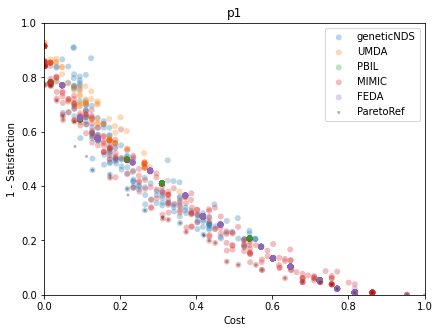

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.8793,0.0376,0.0439,0.6453,800.8662
1,UMDA,0.8783,0.0444,0.0527,0.6236,84.4473
2,PBIL,0.8948,0.0256,0.0468,0.6038,452.2194
3,MIMIC,0.9040,0.0701,0.0340,0.5922,49.2673
4,FEDA,0.8787,0.0368,0.0500,0.6795,554.5325


---------------------------------------------------------------
Pareto Reference has 283 points
Maximum UNFR possible is 10/283=0.0353


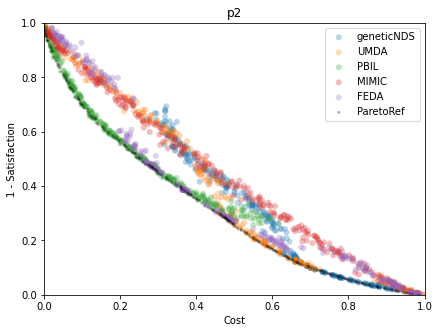

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.6844,0.0068,0.0561,0.6608,2213.7621
1,UMDA,0.7712,0.0033,0.0458,0.5759,335.5445
2,PBIL,0.7390,0.0042,0.0113,0.5571,1024.6246
3,MIMIC,0.7281,0.0002,0.0728,0.5962,107.9203
4,FEDA,0.7886,0.0025,0.0299,0.6018,3037.3493


---------------------------------------------------------------
Pareto Reference has 145 points
Maximum UNFR possible is 10/145=0.0690


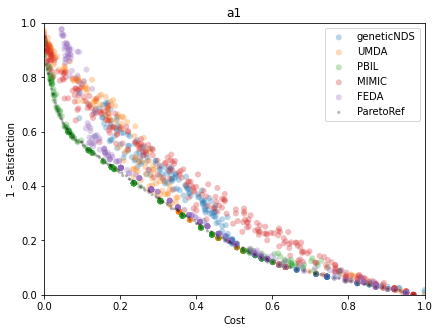

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.8150,0.0274,0.0370,0.6649,1193.1049
1,UMDA,0.8639,0.0271,0.0300,0.5756,174.7565
2,PBIL,0.8968,0.0480,0.0031,0.6078,698.1781
3,MIMIC,0.8191,0.0048,0.0602,0.6004,45.3978
4,FEDA,0.8728,0.0117,0.0179,0.5812,1427.4162


---------------------------------------------------------------
Pareto Reference has 91 points
Maximum UNFR possible is 10/91=0.1099


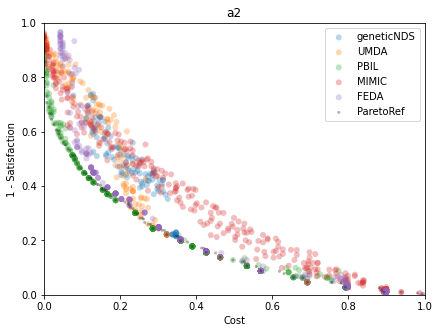

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.8877,0.0678,0.0338,0.6420,806.1419
1,UMDA,0.9290,0.0462,0.0275,0.5923,136.8646
2,PBIL,0.9736,0.0751,0.0027,0.6097,548.6406
3,MIMIC,0.8635,0.0022,0.0699,0.5908,28.7928
4,FEDA,0.9435,0.0136,0.0174,0.6313,662.6650


---------------------------------------------------------------
Pareto Reference has 306 points
Maximum UNFR possible is 10/306=0.0327


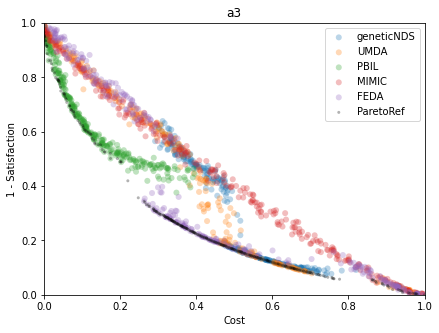

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.7022,0.0020,0.0805,0.7520,1504.1177
1,UMDA,0.8031,0.0031,0.0663,0.5809,344.3830
2,PBIL,0.6558,0.0022,0.0275,0.5703,828.3615
3,MIMIC,0.7382,0.0003,0.1015,0.5972,250.8806
4,FEDA,0.8238,0.0041,0.0454,0.5921,2268.7561


---------------------------------------------------------------
Pareto Reference has 303 points
Maximum UNFR possible is 10/303=0.0330


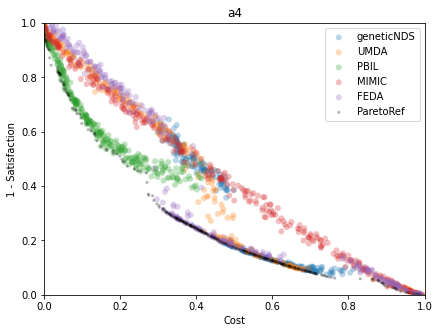

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.6978,0.0050,0.0637,0.7291,1761.2607
1,UMDA,0.7923,0.0023,0.0637,0.5875,375.8887
2,PBIL,0.6576,0.0013,0.0237,0.5685,874.9545
3,MIMIC,0.7341,0.0003,0.0948,0.6054,151.8143
4,FEDA,0.8022,0.0035,0.0494,0.6169,2775.3945


---------------------------------------------------------------
Pareto Reference has 155 points
Maximum UNFR possible is 10/155=0.0645


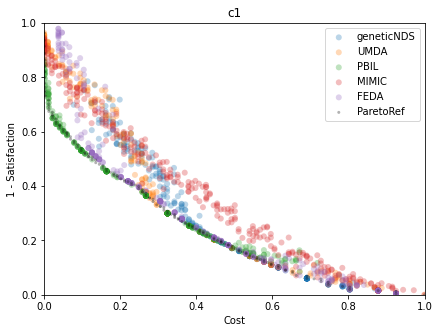

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.8468,0.0318,0.0338,0.6418,1369.9759
1,UMDA,0.8817,0.0273,0.0301,0.6068,223.7486
2,PBIL,0.9030,0.0443,0.0037,0.6150,743.3746
3,MIMIC,0.8337,0.0054,0.0645,0.5797,41.9087
4,FEDA,0.8967,0.0155,0.0170,0.6054,1202.8190


---------------------------------------------------------------
Pareto Reference has 163 points
Maximum UNFR possible is 10/163=0.0613


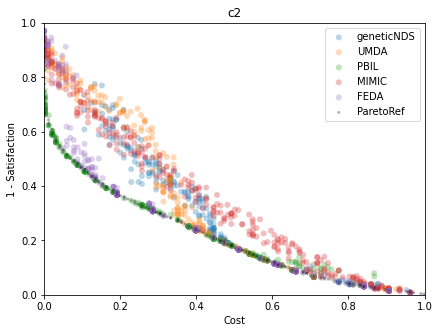

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.8252,0.0247,0.0509,0.6707,1099.2675
1,UMDA,0.8584,0.0196,0.0505,0.5627,185.9247
2,PBIL,0.9421,0.0462,0.0030,0.6031,716.0132
3,MIMIC,0.8342,0.0033,0.0729,0.5985,52.1515
4,FEDA,0.9320,0.0380,0.0072,0.5564,1342.6053


---------------------------------------------------------------
Pareto Reference has 124 points
Maximum UNFR possible is 10/124=0.0806


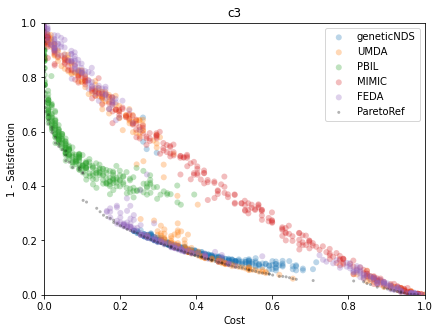

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.8080,0.0016,0.0173,0.7739,874.2606
1,UMDA,0.8779,0.0027,0.0611,0.5699,197.7094
2,PBIL,0.7414,0.0043,0.0391,0.6520,531.1763
3,MIMIC,0.7645,0.0013,0.1329,0.5891,169.5128
4,FEDA,0.9061,0.0038,0.0404,0.6381,1115.9604


---------------------------------------------------------------
Pareto Reference has 122 points
Maximum UNFR possible is 10/122=0.0820


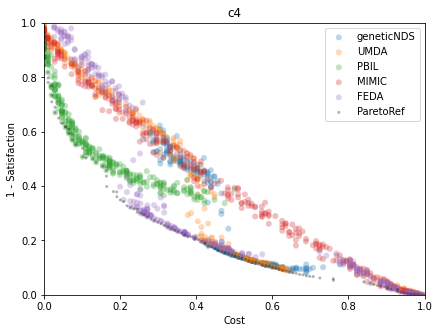

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.7231,0.0025,0.0771,0.7743,820.1618
1,UMDA,0.8204,0.0011,0.0752,0.5832,204.6724
2,PBIL,0.7336,0.0046,0.0408,0.6020,656.5295
3,MIMIC,0.7585,0.0014,0.1115,0.5882,127.9243
4,FEDA,0.8497,0.0057,0.0474,0.6148,1172.4405


---------------------------------------------------------------
Pareto Reference has 205 points
Maximum UNFR possible is 10/205=0.0488


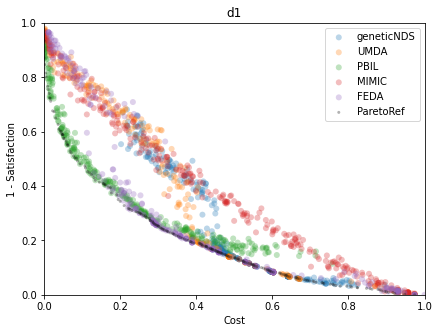

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.7906,0.0132,0.0697,0.7176,1346.1592
1,UMDA,0.8612,0.0101,0.0665,0.5579,239.4590
2,PBIL,0.9033,0.0026,0.0201,0.6027,662.4540
3,MIMIC,0.7948,0.0005,0.1045,0.5806,146.9971
4,FEDA,0.9060,0.0132,0.0270,0.6000,1907.2975


---------------------------------------------------------------
Pareto Reference has 168 points
Maximum UNFR possible is 10/168=0.0595


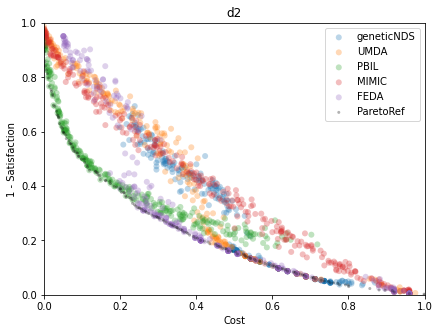

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.7608,0.0218,0.0757,0.7147,939.1621
1,UMDA,0.8304,0.0135,0.0732,0.5560,209.9717
2,PBIL,0.8559,0.0044,0.0268,0.5932,671.5176
3,MIMIC,0.7837,0.0012,0.1022,0.5718,69.7881
4,FEDA,0.8702,0.0228,0.0337,0.6145,1414.7278


---------------------------------------------------------------
Pareto Reference has 306 points
Maximum UNFR possible is 10/306=0.0327


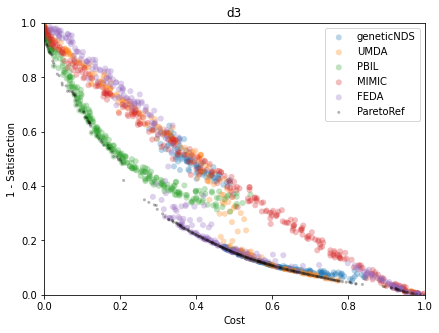

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.7073,0.0064,0.0629,0.7581,1813.7526
1,UMDA,0.7945,0.0035,0.0717,0.5627,338.0281
2,PBIL,0.7197,0.0021,0.0388,0.5822,979.6848
3,MIMIC,0.7384,0.0002,0.1022,0.5939,127.7613
4,FEDA,0.8098,0.0040,0.0514,0.5935,2108.9927


---------------------------------------------------------------
Pareto Reference has 294 points
Maximum UNFR possible is 10/294=0.0340


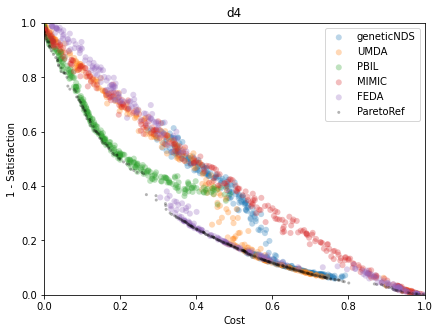

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.6969,0.0022,0.0820,0.7401,1775.7885
1,UMDA,0.8006,0.0045,0.0558,0.5709,397.6439
2,PBIL,0.6934,0.0015,0.0263,0.5751,1184.9404
3,MIMIC,0.7375,0.0003,0.0929,0.5975,119.4725
4,FEDA,0.8080,0.0027,0.0461,0.5963,3208.9304


---------------------------------------------------------------
Pareto Reference has 262 points
Maximum UNFR possible is 10/262=0.0382


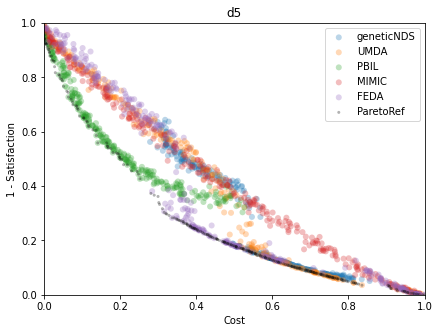

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.7019,0.0004,0.0721,0.7259,1916.8350
1,UMDA,0.7842,0.0036,0.0667,0.5800,328.0819
2,PBIL,0.7197,0.0028,0.0307,0.5789,885.8085
3,MIMIC,0.7459,0.0000,0.0892,0.5953,145.8403
4,FEDA,0.8090,0.0038,0.0487,0.5953,2356.9579


---------------------------------------------------------------
Pareto Reference has 275 points
Maximum UNFR possible is 10/275=0.0364


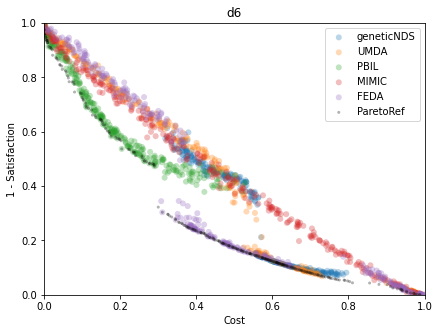

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.6686,0.0030,0.0786,0.7611,1568.3957
1,UMDA,0.7632,0.0015,0.0691,0.5703,359.8537
2,PBIL,0.6441,0.0029,0.0327,0.5626,1200.1904
3,MIMIC,0.7262,0.0004,0.0880,0.5931,351.0875
4,FEDA,0.7980,0.0025,0.0429,0.6004,2437.1066


---------------------------------------------------------------
Pareto Reference has 325 points
Maximum UNFR possible is 10/325=0.0308


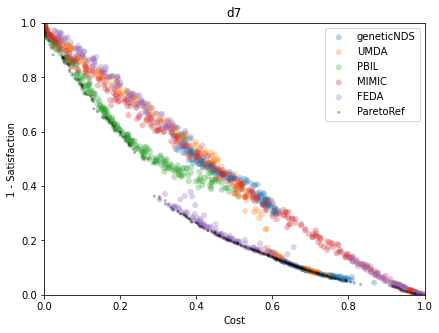

,Method,HV,UNFR,gd+,spread,time(s)
0,geneticNDS,0.6545,0.0063,0.0896,0.7401,2144.0206
1,UMDA,0.7503,0.0012,0.0658,0.5694,369.0416
2,PBIL,0.6451,0.0023,0.0324,0.5723,1221.0485
3,MIMIC,0.7204,0.0002,0.0831,0.6000,222.3327
4,FEDA,0.7791,0.0018,0.0432,0.6063,3178.8110


---------------------------------------------------------------
Wins Counts:
{'geneticNDS': 0, 'UMDA': 0, 'PBIL': 4, 'MIMIC': 1, 'FEDA': 12}
Wins in datasets:
{'geneticNDS': [], 'UMDA': [], 'PBIL': ['a1', 'a2', 'c1', 'c2'], 'MIMIC': ['p1'], 'FEDA': ['p2', 'a3', 'a4', 'c3', 'c4', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']}


In [33]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt

algorithms = ['geneticNDS', 'UMDA', 'PBIL', 'MIMIC',  'FEDA' ] #['geneticNDS', 'UMDA', 'PBIL', 'GRASP', 'FEDA']  ['geneticNDS', 'UMDA', 'PBIL', 'FEDA' ]
#display(best_for_grasp_df)


files_all_algorithms =[ #call with best_for_... in the same order than algorithms in list algorithms above
    get_files_list_with_best_configuration(best_for_geneticnds_df,datasets_names),
    get_files_list_with_best_configuration(best_for_umda_df,datasets_names),
    get_files_list_with_best_configuration(best_for_pbil_df,datasets_names),
    #get_files_list_with_best_configuration(best_for_grasp_df,datasets_names),
    get_files_list_with_best_configuration(best_for_mimic_df,datasets_names),
    get_files_list_with_best_configuration(best_for_feda_df,datasets_names),
    
    
    
    
    
] 


wins_counts =  {}
wins_datasets = {}
for alg in algorithms:
    wins_counts[alg] = 0
    wins_datasets[alg] = []
 

# print 30 (or the number of execution) paretos of each dataset
# (maybe one plot per dataset, and all differente algorithms in each plot)


for i in range(0,len(datasets_names)):
    fig = plt.figure(figsize=(15,5)) #20,5 when plotting also ax2 with table
    #ax =fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(121)
    ax.set_xlabel('Cost')
    ax.set_ylabel('1 - Satisfaction')
    ax.set_title(datasets_names[i])
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)"])
    
    for j in range(0,len(algorithms)):    
        try:
            file = files_all_algorithms[j][i] #they are ordered by dataset list initiated in first cell
            with open(file, 'r') as f:
                dictio = json.load(f)
            paretos_list = dictio['paretos']
            dataset = dictio['parameters']['dataset']
            metrics = dictio['metrics']
            pareto_reference = dictio['Reference_Pareto'] # any algorithm j has/should have the same PR for the same dataset. we use the last (same) after this loop
            
            (hv, unfr, gdplus, spread, time) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'])
            new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=4), 'UNFR':np.mean(unfr).round(decimals=4), 'gd+':np.mean(gdplus).round(decimals=4), 'spread':np.mean(spread).round(decimals=4), 'time(s)':np.mean(time).round(decimals=4)}
            
            for pareto in paretos_list: 
                x = [item[0] for item in pareto]
                y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
                plt.scatter(x, y, color='C'+str(j), alpha=0.3, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
                    
            
            summary_df = summary_df.append(new_row, ignore_index=True)
        except(FileNotFoundError, IOError):
            print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")
        
    
    # update wins counts
    idx = summary_df['HV'].idxmax()
    winner = summary_df.loc[idx]['Method']
    wins_counts[winner] = wins_counts[winner] + 1
    wins_datasets[winner].extend([datasets_names[i]])

    # print pareto reference
    print(f"Pareto Reference has {len(pareto_reference)} points")
    max_unfr = len(pareto) / len(pareto_reference)
    print(f"Maximum UNFR possible is {len(pareto)}/{len(pareto_reference)}={max_unfr:.4f}")
    x = [item[0] for item in pareto_reference]
    y = [1-item[1] for item in pareto_reference] #revert satisfaction. 0,0 is best point
    plt.scatter(x, y, color='black', alpha=0.3, edgecolors='none', label='ParetoRef', marker='.') 


    handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())        
    #ax2 = fig.add_subplot(122) #comment to avoid table be printed next to plot
    #ax2.axis('off')
    #bbox=[0, 0, 1, 1]
    
    #mpl_table = ax2.table(cellText = summary_df.values, rowLabels = summary_df.index, bbox=bbox, colLabels=summary_df.columns)
    #mpl_table.auto_set_font_size(False)
    #mpl_table.set_fontsize(12)


    plt.show()
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_df) # print in copy-paste format
    print("---------------------------------------------------------------")

print("Wins Counts:") 
print(wins_counts)
print("Wins in datasets:")
print(wins_datasets)
            
             






## 4. FEDA description:
    Given an initial set of requirements dependencies in the form of
    X1-->X2, FEDA uses this knowledge as a prefixed structure.
    e.g: we can have an acyclic graph like this: G={0-->2, 1-->2, 3, 2-->4}, where requirements 0,1,3 do not have parents,
    parents(2)={0,1} and parents(4)={2}.

    Thus, learning is not structural and only applies to data.
    Sampling is always performed following a topological (ancestral) order ([3,0,1,2,4] in the example above).

    Algorithm is as follows:

    1. Sampling of First generation:
    -- If X does not have any parents, then sample using  P(X)=1/num_requirements
    -- If any Y in parents(X) is set to 1, then X=1, else use P(X)=1/num_requirements

    do

        2. Learning
        -- If X does not have any parents in graph structure, then learn its marginal probability
        -- If X does have parents in graph structure, learn Conditional: P(X| all Y in parents(X)==0) In the example above, P(2| 0==0,1==0).
        Thus, we only need to learn P(X|parents(X)) from requirements whose parents Y are not selected.
        That is, we do not need P(X | any parents(X)==1), just the all parents(X)==0 case.
        This means that conditional probability can be stored in a unidimensional array,
         using the same array to store either marginal or conditional probability for each X.

        3. Sampling
        -- In the case of requirements without parents in graph structure, use learned marginal probability
        -- In any Y in parents(X) is set to 1, then X=1, else use P(X|parents(X)==0)

    while(!stop_criterion)

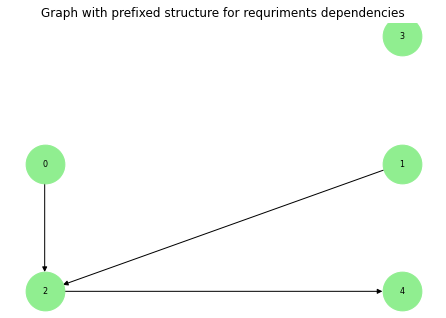

In [5]:
# https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python
import networkx as nx

import matplotlib.pyplot as plt

G = nx.DiGraph()
nodes = {0: (1,2), 1: (2,2), 2: (1,1), 4: (2,1), 3: (2,3)}
G.add_nodes_from(nodes.keys())
G.add_edges_from([(0,2), (1,2), (2,4)])
#arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))

for n, p in nodes.items():
   G.nodes[n]['pos'] = p

nx.draw(G, pos=nodes, with_labels=True, font_size=8, node_size=1500, node_color='lightgreen')
ax = plt.gca()
ax.set_title('Graph with prefixed structure for requriments dependencies')
plt.show()

Ancestral order: [3,0,1,2,4]

##### a) Sampling of first generation:

In the dependencies structure shown above, when sampling the first set of solutions, the requirement in each solution is selected given the following probabilites:

P(3) = 1/5

P(0) = 1/5

P(1) = 1/5

P(2) = 1 if requirement 0 or 1 has been selected in current solution; 1/5 otherwise.

P(4) = 1 if requirement 2 has been selected in current soluction; 1/5 otherwise.

Let us assume that we sample 6 individuals with the following result:

solutions = 
            
            [ [0 0 1 0 1]

              [1 0 1 1 1]

              [0 1 1 0 1]

              [0 0 0 0 0]

              [0 1 1 0 1]
              
              [0 1 0 1 1]

              [0 0 0 1 0]
            ]
            
An impossible sampled individual would be, for example: [0 1 0 0 1] because requirement 2 should be selected since requirement 1 is.
Thus, the dependencies graph structured is respected.

The whole population is evaluated, and the local NDS in current iteration set is identified. Let us assume this NDS:

nds_local = 

            [
             [1 0 1 1 1]

             [0 0 1 0 1]

             [0 1 0 1 1]

             [0 0 0 1 0]
            ]

nds_global = nds_local

##### b) Learning
This step consists in updating the sampling probability of each requirement from the nds_local population. 

P(0) = 1/4  

P(1) = 1/4

P(2) = P_nds_local(2|requirement_0=0 and requirement_1=0) = 1/2

P(3) = 2/4

P(4) = P_nds_local(4|requirement_0=0) = 2/3

Thus, our probabilities vector is now:

probabilities =

            [0.25, 0.25, 0.5, 0.5, 0.66]
 

 #### Sidenote about learning

we could have special cases in which a requirement is never selected. For instance, let us imagine this local NDS:

nds_local = 

            [
             [1 0 1 1 1]

             [0 0 1 0 1]

             [0 0 0 1 1]
            ]

P(1) = 0, so sampling of new individuals would not select requirement 1 anymore. In this case, we keep P(1) as its previous stored probability.
Another possible alleaviations to this cases could be learning P(1) from the global NDS, or using some smooth.




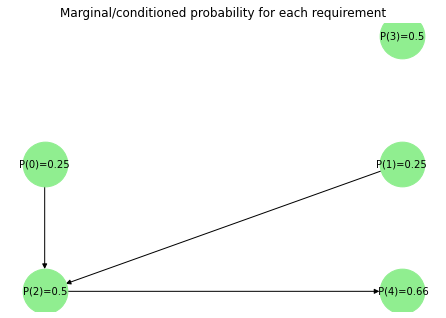

In [8]:
G = nx.DiGraph()
nodes = {0: (1,2), 1: (2,2), 2: (1,1), 4: (2,1), 3: (2,3)}
G.add_nodes_from(nodes.keys())
G.add_edges_from([(0,2), (1,2), (2,4)])
#arcs = nx.draw_networkx_edges(G, pos=nx.spring_layout(G))

for n, p in nodes.items():
   G.nodes[n]['pos'] = p

labeldict = {0: "P(0)=0.25", 1: "P(1)=0.25",2: "P(2)=0.5",3: "P(3)=0.5",4: " P(4)=0.66"}


nx.draw(G, pos=nodes, labels=labeldict, with_labels=True, font_size=10, node_size=2000, node_color='lightgreen')
ax = plt.gca()
ax.set_title('Marginal/conditioned probability for each requirement')
plt.show()

##### c) Sampling

Each new individual is sampled given the Ancestral order: [3,0,1,2,4], and using the following probabilities:

P(3) = 0.5

P(0) = 0.25

P(1) = 0.25

P(2) = 1 if requirement 0 or 1 is selected. 0.5 otherwise.

P(4) = 1 if requirement 2 is selected. 0.66 otherwise.

Let us assume that we sample 6 individuals with the following result:

new_solutions = 
            
            [ [0 0 0 1 1]

              [0 0 1 1 1]

              [1 1 1 0 1]

              [0 0 1 1 1]

              [0 0 0 1 0]
              
              [0 0 0 0 1]
            ]
 
 We evaluate the solutions to:
 - update the global NDS given the new_solution population 
 - set local NDS to the nds found in new_soluction population 


Repeat Learning+Sampling until stop criterion.

### 3. Pareto plots for each algorithm, set with best configuration of FEDA 

In [ ]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt


feda_best_pop_length = int(best_config_feda["population_length"])
feda_best_max_generations = int(best_config_feda["max_generations"])


algorithms = ['geneticNDS', 'UMDA', 'PBIL', 'FEDA' ] #['geneticNDS', 'UMDA', 'PBIL', 'GRASP', 'FEDA']
#display(best_for_grasp_df)

files_all_algorithms =[
    get_files_list_with_best_configuration(best_for_geneticnds_df,datasets_names),
    get_files_list_with_best_configuration(best_for_umda_df,datasets_names),
    get_files_list_with_best_configuration(best_for_pbil_df,datasets_names),
    get_files_list_with_best_configuration(best_for_feda_df,datasets_names),
    
    
    #get_files_list_with_best_configuration(best_for_grasp_df,datasets),
    
    
] 


for i in range(0,len(datasets_names)):
    fig = plt.figure()
    ax =fig.add_axes([0,0,1,1])
    ax.set_xlabel('Cost')
    ax.set_ylabel('1 - Satisfaction')
    ax.set_title(datasets_names[i])
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)"])

    for j in range(0,len(algorithms)):    
        file = files_all_algorithms[j][i] #they are ordered by dataset list above
        with open(file, 'r') as f:
            dictio = json.load(f)
        paretos_list = dictio['paretos']
        dataset = dictio['parameters']['dataset']
        metrics = dictio['metrics']
        (hv, gdplus, unfr, spread, time) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'])
        new_row = {'Method': algorithms[j], 'HV':np.mean(hv), 'UNFR':np.mean(unfr), 'gd+':np.mean(gdplus), 'spread':np.mean(spread), 'time(s)':np.mean(time)}
        
        for pareto in paretos_list: 
            x = [item[0] for item in pareto]
            y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
            plt.scatter(x, y, color='C'+str(j), alpha=0.3, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
        
        summary_df = summary_df.append(new_row, ignore_index=True)
        

    handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())        
    plt.show()
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_df)
    print("---------------------------------------------------------------")



### 3. Statistical tests of quality indicators